#  *Second stage*: ML
The goal is to predict `SalePrice`.<br>


The packages to apply:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits import mplot3d
from matplotlib import cm

In [2]:
data=pd.read_csv("data_ml.csv")

In [3]:
data.shape

(1460, 172)

In [4]:
data.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.75,0.150685,0.033420,1.0,1.0,1.0,0.0,1.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.75,0.202055,0.038795,1.0,1.0,1.0,0.0,0.5,0.0,0.125,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.75,0.160959,0.046507,1.0,0.0,1.0,0.0,1.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.75,0.133562,0.038561,1.0,0.0,1.0,0.0,0.0,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.75,0.215753,0.060576,1.0,0.0,1.0,0.0,0.5,0.0,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


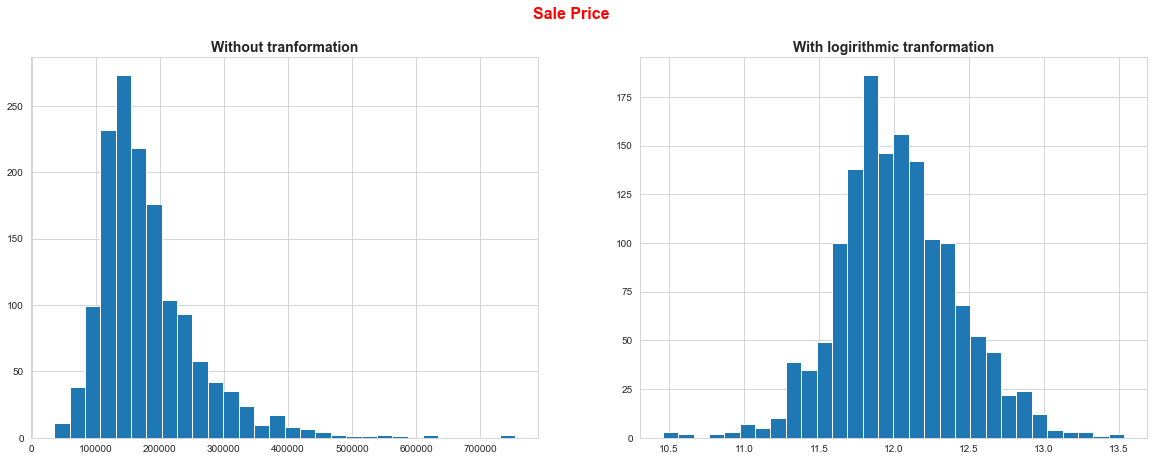

In [5]:
fig,ax=plt.subplots(1,2,figsize=(20,7))
ax[0].hist(data.SalePrice,bins=30)
ax[0].set_title('Without tranformation',fontsize=14,fontweight="bold")
ax[1].hist(np.log(data.SalePrice),bins=30)
ax[1].set_title('With logirithmic tranformation', fontsize=14 ,fontweight="bold")
plt.suptitle("Sale Price",fontsize=16,color="red",fontweight="bold")
plt.show()

For the case of logarithmic scale, the target attribute shows a better distribution. Therefore the model will be trained for that scale as well. 

Splitting dataset:

In [6]:
from sklearn.model_selection import train_test_split,cross_validate
data_train , data_test = train_test_split(data,test_size=0.2,random_state=141) 

**data_train** 

In [7]:
train_x=data_train.drop(columns="SalePrice")
train_y=data_train["SalePrice"]

**data_test**

In [8]:
test_x=data_test.drop(columns="SalePrice")
test_y=data_test["SalePrice"]

To ignore warnings:

In [9]:
import warnings
warnings.filterwarnings('ignore')

It will only be applied the  following supervised methods:
- Linear Regression
- K-Nearest Neighbor
- Gradient Boostinging 
- Random Forest 
- Support Vector Machine
- Neural Network

In [10]:
#titles of graphs 
val_curv="Validation curve"
com_target="Comparison of target"
val_curv_trans="Validation curve with target transformed"
com_target_trans="Comparison of target with previous logarithmic transformation"

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
main_kfold = KFold(10, shuffle=True, random_state=45)
from sklearn.compose import TransformedTargetRegressor

## Linear Regression 

In [12]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', LinearRegression(n_jobs=-1))])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 1.6 s


Pipeline(steps=[('scale', RobustScaler()), ('lr', LinearRegression(n_jobs=-1))])

In [13]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 15282.17


In [14]:
predict_y=lr_pipe.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 10317527532.18


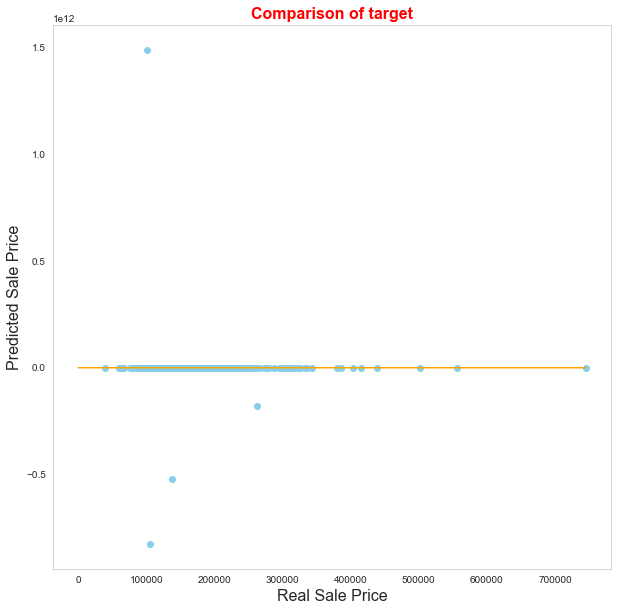

In [15]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

### Logarithmic scale

In [16]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#fit the model to data
lr_trans.fit(train_x, train_y)

Wall time: 793 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr',
                                                      LinearRegression(n_jobs=-1))]))

In [17]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 12917.47


In [18]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 18188.83


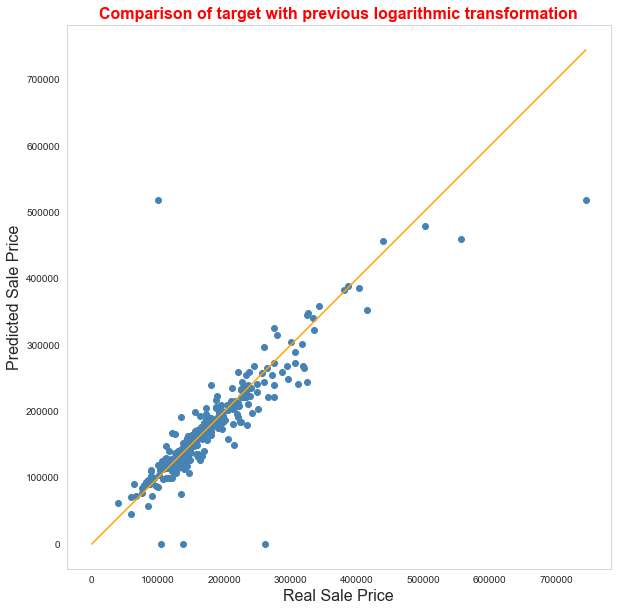

In [19]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## K-Nearest Neighbor

In [20]:
%%time
n_neighbors= np.arange(3,25,2)
from sklearn.neighbors import KNeighborsRegressor

#create a knn model
knn = KNeighborsRegressor(p=1,n_jobs=-1)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": n_neighbors}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
knn_gscv.fit(train_x, train_y)

Wall time: 699 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

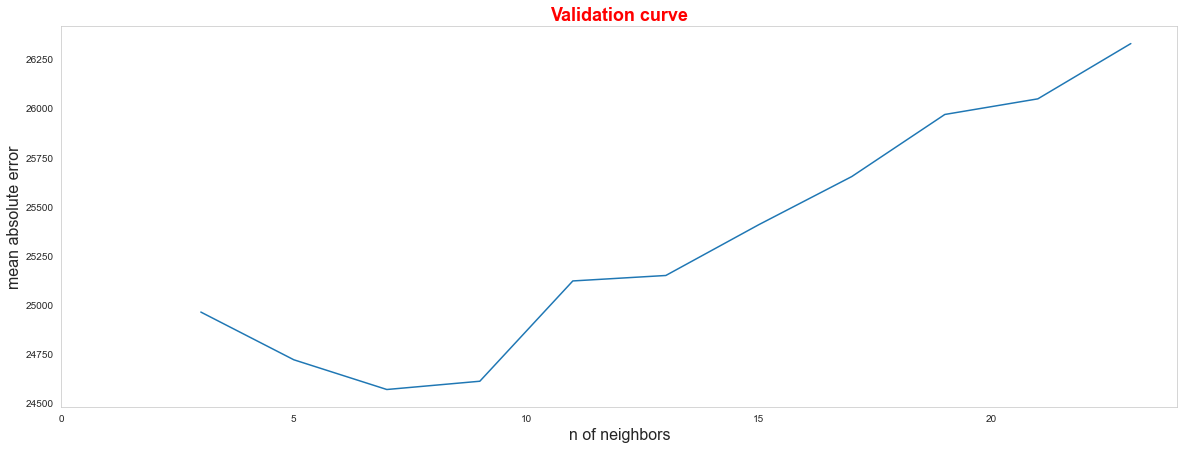

In [21]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv.cv_results_['mean_test_score']) 
plt.title(val_curv,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [22]:
predict_y=knn_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 24311.16


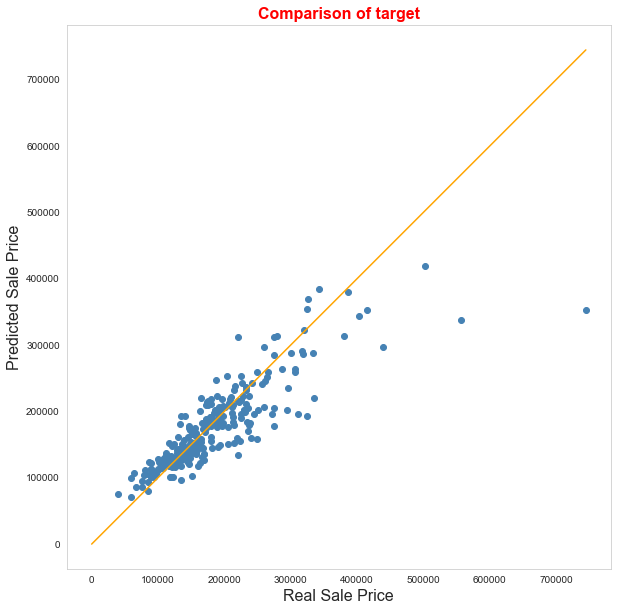

In [23]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

### Logarithmic scale

In [24]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(knn,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_neighbors':n_neighbors}
knn_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
knn_gscv_trans.fit(train_x, train_y)

Wall time: 659 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=KNeighborsRegressor(n_jobs=-1,
                                                                                                 p=1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

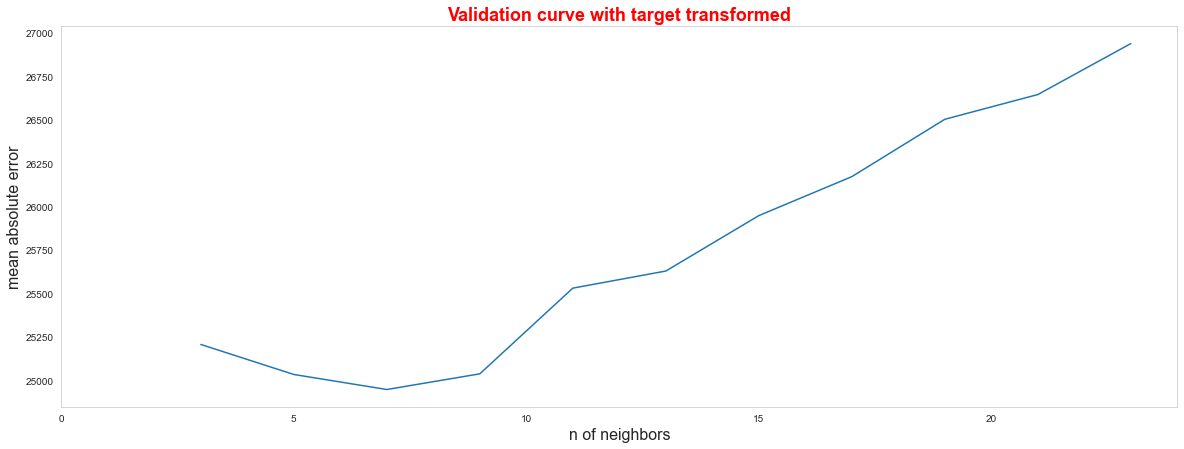

In [25]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv_trans.cv_results_['mean_test_score']) 
plt.title(val_curv_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [26]:
predict_y=knn_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 24581.15


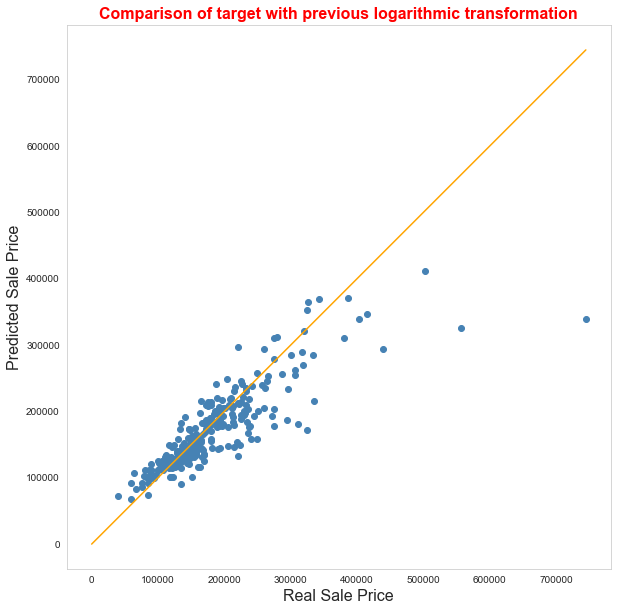

In [27]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

## Gradient Boosting

In [28]:
%%time
N=np.array([15,50,100,300,500,800])
from sklearn.ensemble import GradientBoostingRegressor 

#create a gb model
gb = GradientBoostingRegressor(loss='absolute_error')
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_estimators": N}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
gb_gscv = GridSearchCV(gb, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
gb_gscv.fit(train_x, train_y)

Wall time: 24.8 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=GradientBoostingRegressor(loss='absolute_error'),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

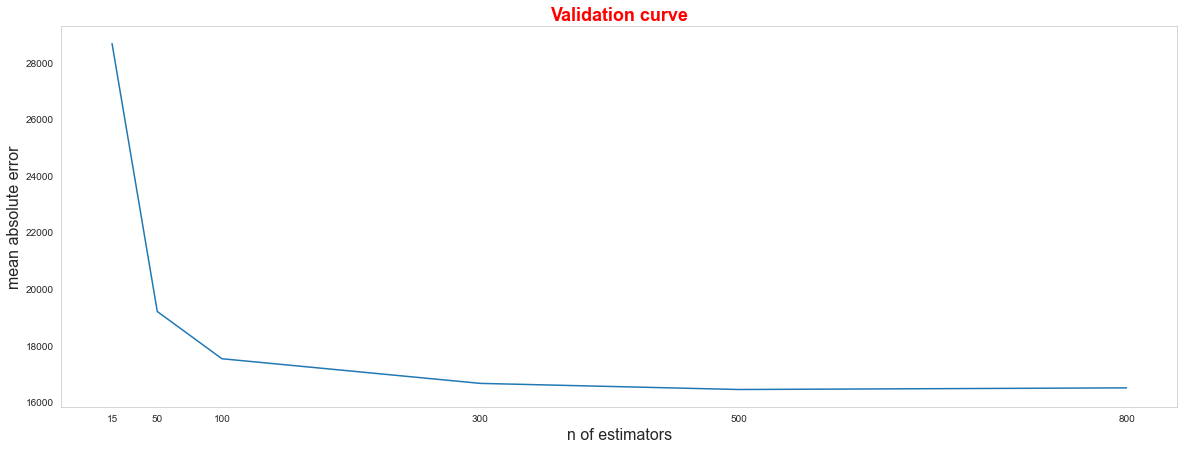

In [29]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv.cv_results_['mean_test_score']) 
plt.title(val_curv,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [30]:
predict_y=gb_gscv.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 14707.58


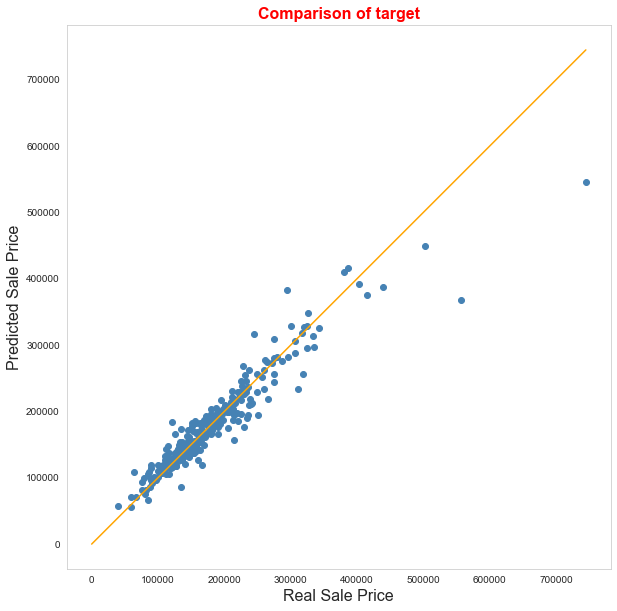

In [31]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

### Logarithmic scale

In [32]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(gb,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
gb_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
gb_gscv_trans.fit(train_x, train_y)

Wall time: 24.5 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=GradientBoostingRegressor(loss='absolute_error')))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

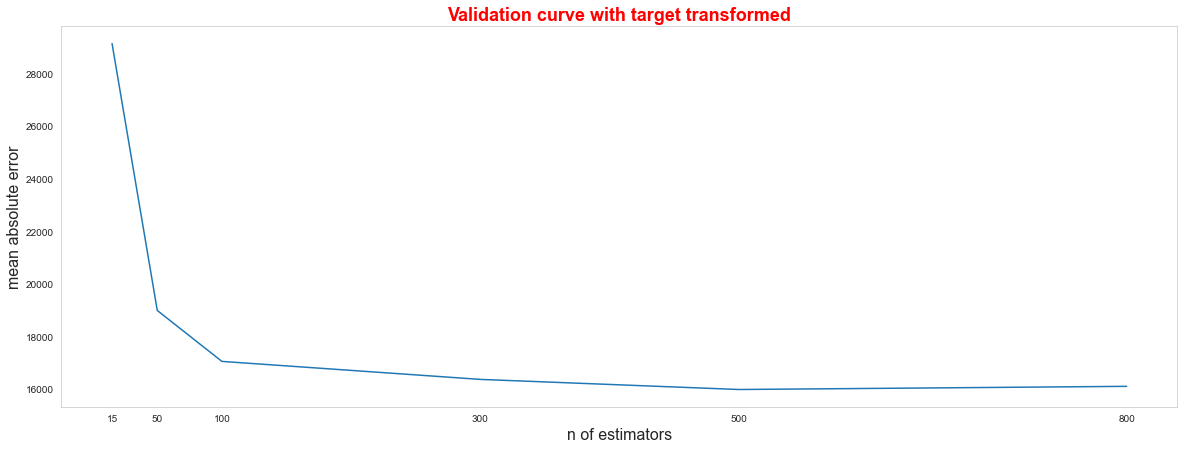

In [33]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv_trans.cv_results_['mean_test_score']) 
plt.title(val_curv_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [34]:
predict_y=gb_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 14586.3


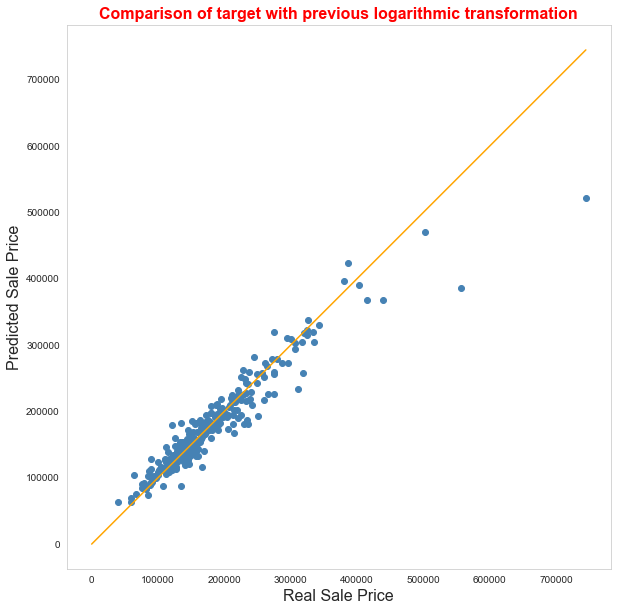

In [35]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()   

## Random Forest

In [36]:
%%time
N=np.array([15,50,100,250,300,350])
from sklearn.ensemble import RandomForestRegressor 

#create a rf model
rf = RandomForestRegressor(criterion='absolute_error',n_jobs=-1)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_estimators": N}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
rf_gscv = GridSearchCV(rf, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
rf_gscv.fit(train_x, train_y)

Wall time: 4min 37s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(criterion='absolute_error',
                                             n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

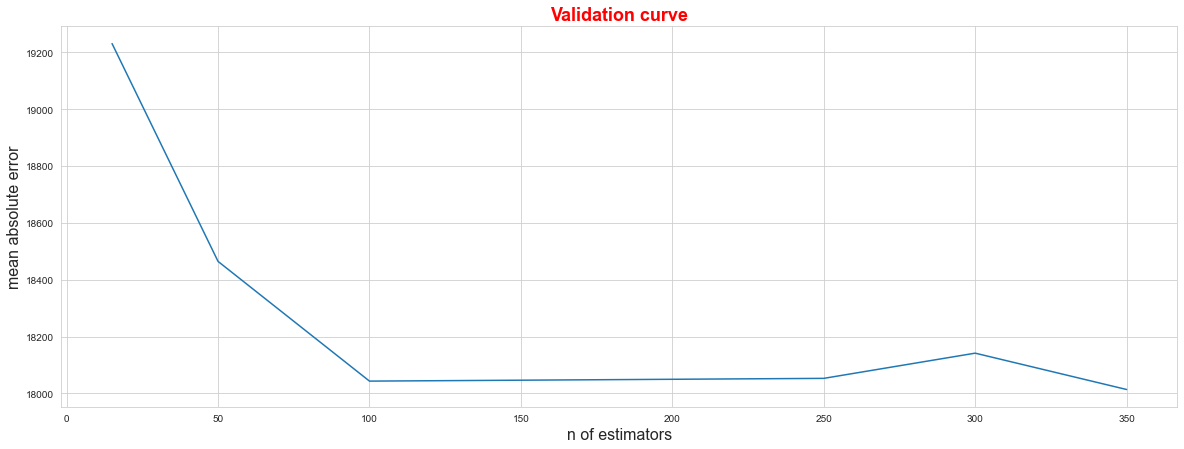

In [37]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv.cv_results_['mean_test_score']) 
plt.title(val_curv,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [38]:
predict_y=rf_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 17343.9


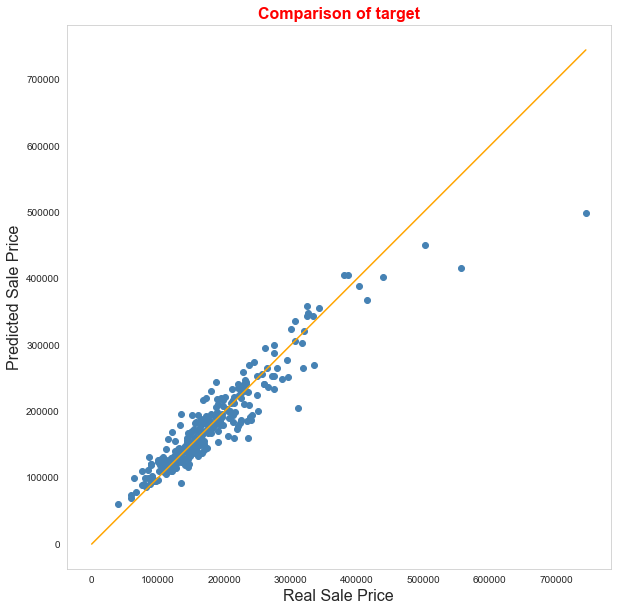

In [39]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### Logarithmic scale

In [40]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(rf,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
rf_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
rf_gscv_trans.fit(train_x, train_y)

Wall time: 4min 39s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor(criterion='absolute_error',
                                                                                                   n_jobs=-1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

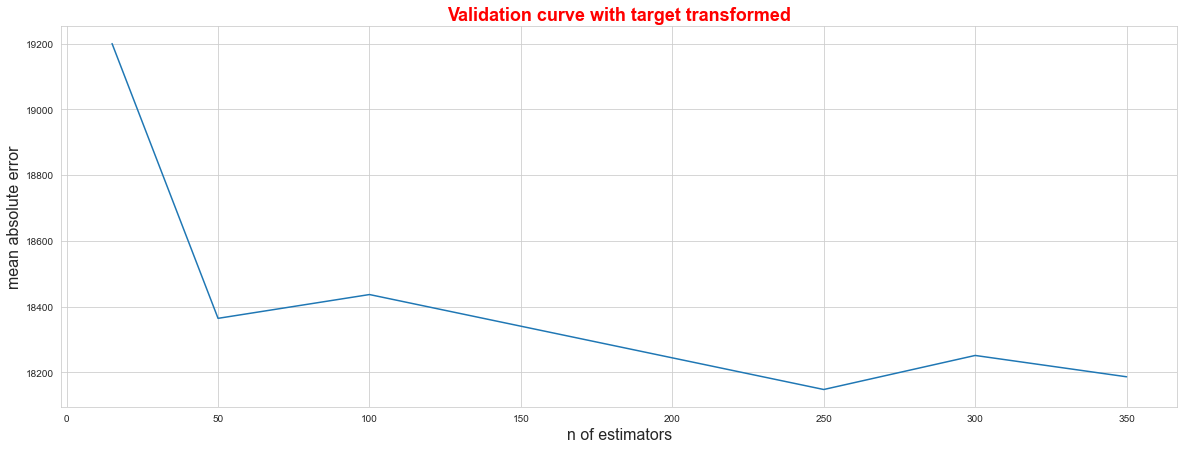

In [41]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv_trans.cv_results_['mean_test_score']) 
plt.title(val_curv_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [42]:
predict_y=rf_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 17412.46


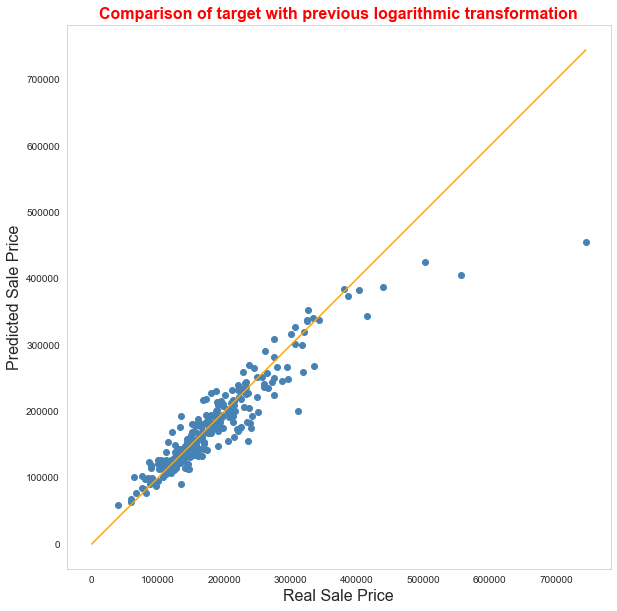

In [43]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## Decision Tree

In [44]:
%%time
min_samples_split= [2,6,10,16,20,25]
from sklearn.tree import DecisionTreeRegressor 

#create a td model
dt = DecisionTreeRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"min_samples_split": min_samples_split}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
dt_gscv = GridSearchCV(dt, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
dt_gscv.fit(train_x, train_y)

Wall time: 382 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [2, 6, 10, 16, 20, 25]},
             scoring='neg_mean_absolute_error')

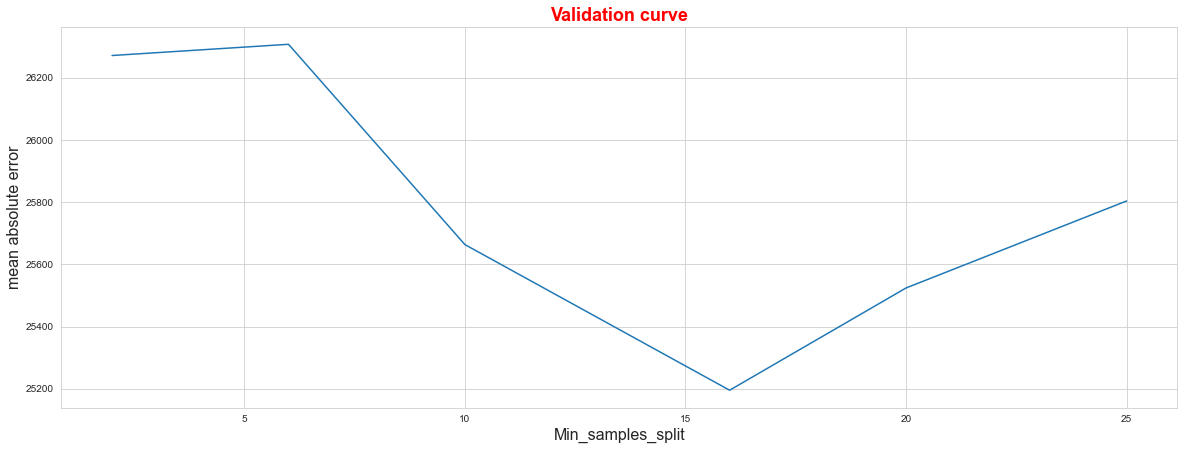

In [45]:
plt.figure(figsize=(20,7))
plt.plot(min_samples_split, -dt_gscv.cv_results_['mean_test_score']) 
plt.title(val_curv,fontsize=18,color='red',fontweight="bold")
plt.xlabel('Min_samples_split',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [46]:
predict_y=dt_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 25788.48


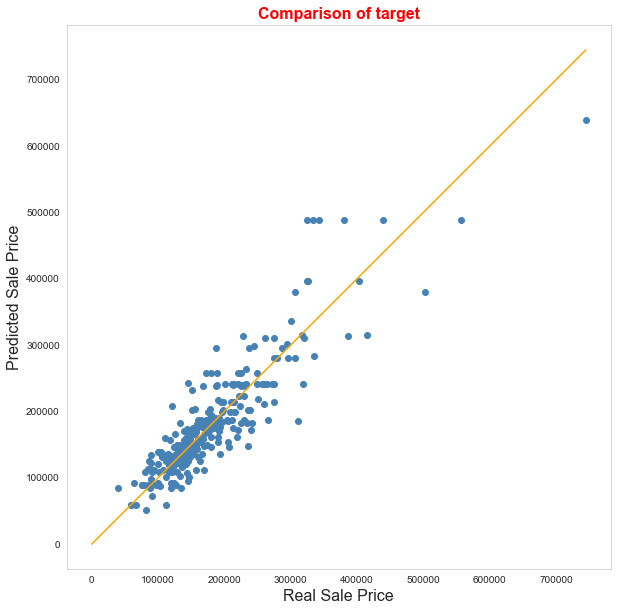

In [47]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### Logarithmic scale

In [48]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(dt,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__min_samples_split':min_samples_split}
dt_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
dt_gscv_trans.fit(train_x, train_y)

Wall time: 408 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=DecisionTreeRegressor()))]),
             n_jobs=-1,
             param_grid={'model__regressor__min_samples_split': [2, 6, 10, 16,
                                                                 20, 25]},
             scoring='neg_mean_absolute_error')

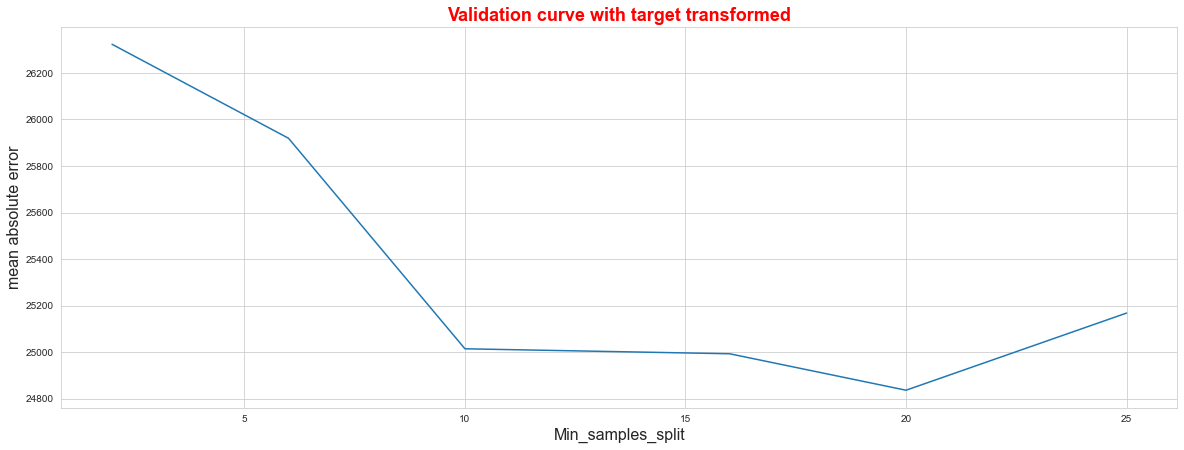

In [49]:
plt.figure(figsize=(20,7))
plt.plot(min_samples_split, -dt_gscv_trans.cv_results_['mean_test_score']) 
plt.title(val_curv_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('Min_samples_split',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [50]:
predict_y=dt_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 25050.81


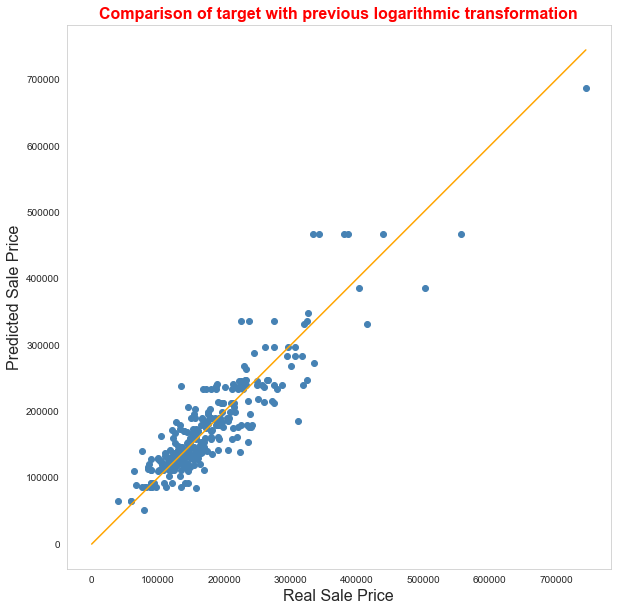

In [51]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## Support Vector Machine

In [52]:
%%time
degree= [5, 10, 15,20]
from sklearn.svm import SVR 

#create a rf model
svm = SVR()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"degree": degree}
#param_grid = [{"n_estimators": N,
    #'max_depth': [5, 20, None],
    #'min_samples_split': [2, 10, 50],
    #'min_samples_leaf': [1, 10, 50],
    #'max_leaf_nodes': [10, 50, None],
    #'max_features': ['sqrt', 'log2', None]
#}]

#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(svm, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit the model to data
svm_gscv.fit(train_x, train_y)

Wall time: 1.18 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=SVR(), n_jobs=-1, param_grid={'degree': [5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

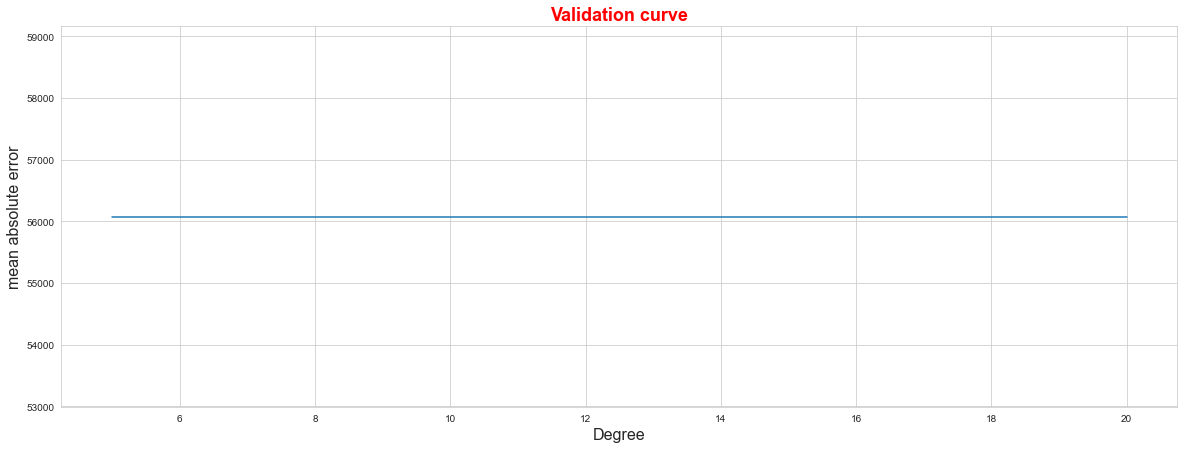

In [53]:
plt.figure(figsize=(20,7))
plt.plot(degree, -svm_gscv.cv_results_['mean_test_score']) 
plt.title(val_curv,fontsize=18,color='red',fontweight="bold")
plt.xlabel('Degree',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [54]:
predict_y=svm_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 53444.06


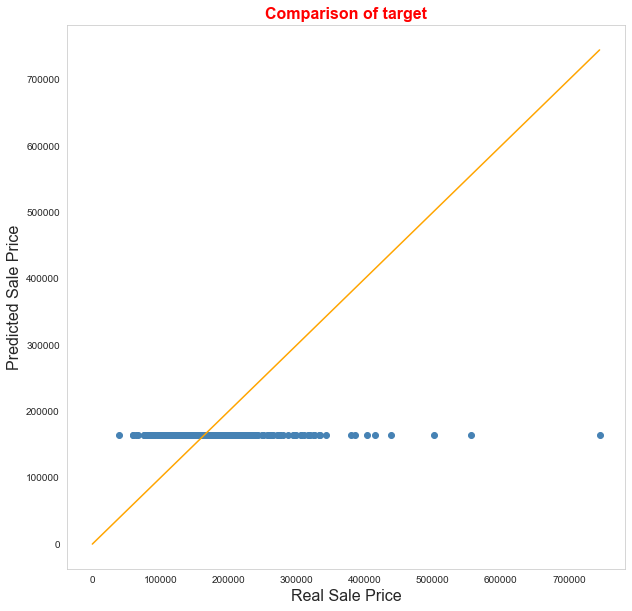

In [55]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue")
#plt.axis('scaled')
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### Logarithmic scale

In [56]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(svm,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__degree':degree}
svm_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
svm_gscv_trans.fit(train_x, train_y)

Wall time: 662 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=SVR()))]),
             n_jobs=-1,
             param_grid={'model__regressor__degree': [5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

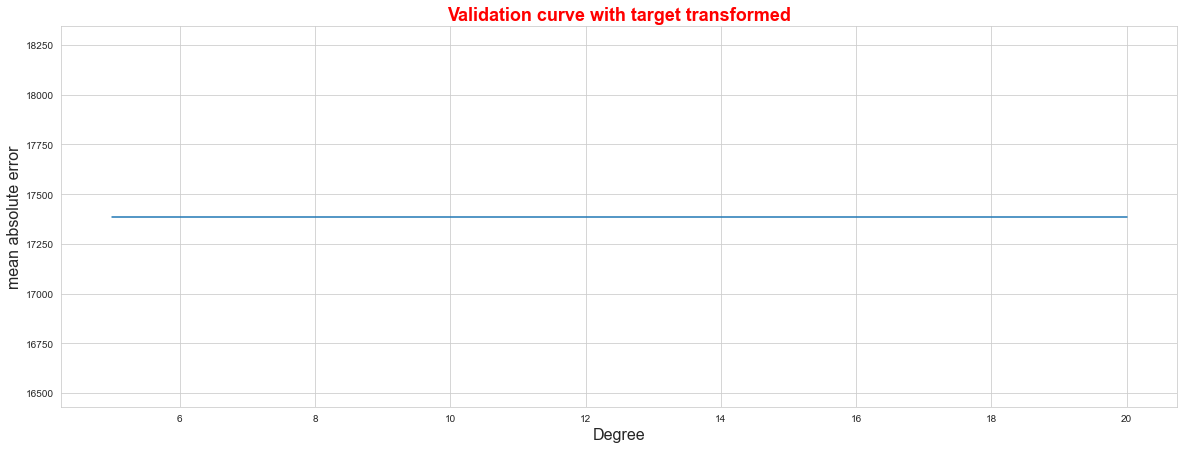

In [57]:
plt.figure(figsize=(20,7))
plt.plot(degree, -svm_gscv_trans.cv_results_['mean_test_score']) 
plt.title(val_curv_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('Degree',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [58]:
predict_y=svm_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 16764.67


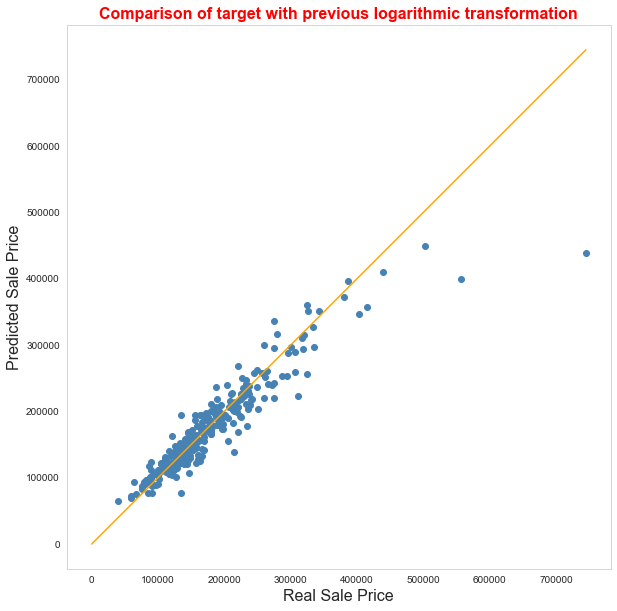

In [59]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

## Neural Network

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

In [61]:
# define the model
def create_model(neurons1,neurons2):
    model=Sequential()
    model.add(Input(train_x.shape[1]))#Numbers of attributes
    model.add(Dense(neurons1, activation='relu'))
    model.add(Dense(neurons2, activation='relu')) 
    #model.add(Dense(n_neurons, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.01),# gradient descent method
                  loss='MeanAbsoluteError',# metric on neuron 
                  metrics=['MeanAbsoluteError'])# metric on output
    return(model) 

In [62]:
%%time
model = KerasRegressor(model=create_model, verbose=0)
N1=np.arange(10,110,step=10)
N2=np.arange(10,110,step=10)
param_grid=dict(model__neurons1=N1,model__neurons2=N2)
nn_gscv = GridSearchCV(model, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit model to data
nn_gscv.fit(train_x,train_y,epochs=30, batch_size=10,verbose=0)

Wall time: 13min 35s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=KerasRegressor(model=<function create_model at 0x00000223CF44E1F0>, verbose=0),
             n_jobs=-1,
             param_grid={'model__neurons1': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                         'model__neurons2': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='neg_mean_absolute_error')

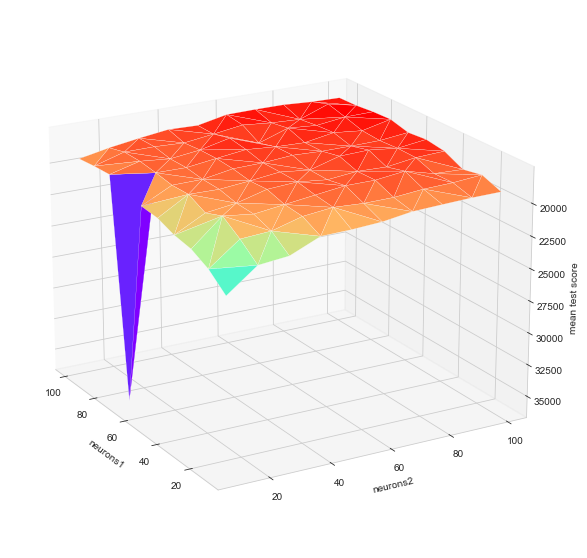

In [63]:
df=pd.DataFrame(nn_gscv.cv_results_['params'])
df.columns=df.columns.str.replace("model__","")
df["mean_test_score"]=-nn_gscv.cv_results_['mean_test_score'].round(2)
#3d graph
fig = plt.figure(figsize=(20,10))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(df.neurons1, df.neurons2, df.mean_test_score, cmap=cm.rainbow_r, linewidth=0.2)
ax.set_xlabel('neurons1',)
ax.set_ylabel('neurons2')
ax.set_zlabel('mean test score')
ax.view_init(-160, 30)
plt.show()

In [64]:
df.iloc[df.mean_test_score.idxmin,:]

neurons1              90.00
neurons2              90.00
mean_test_score    17572.41
Name: 88, dtype: float64

In [65]:
predict_y=nn_gscv.predict(test_x)
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 18184.92


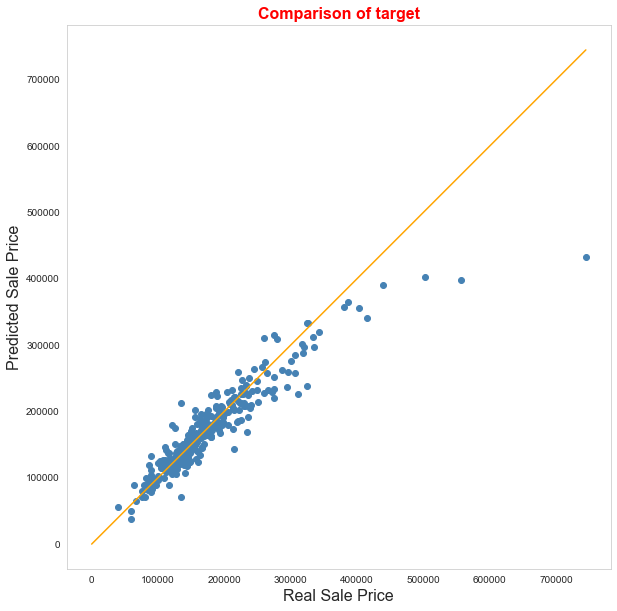

In [66]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### Logarithmic scale

In [67]:
%%time
#model = KerasRegressor(model=create_model, verbose=0)
#N=np.arange(5,95,step=5)
#param_grid=dict(model__n_neurons=N)
#nn_gscv = GridSearchCV(model, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#fit model to data
nn_gscv.fit(train_x,np.log(train_y),epochs=30, batch_size=10,verbose=0)

Wall time: 13min 25s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=KerasRegressor(model=<function create_model at 0x00000223CF44E1F0>, verbose=0),
             n_jobs=-1,
             param_grid={'model__neurons1': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                         'model__neurons2': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='neg_mean_absolute_error')

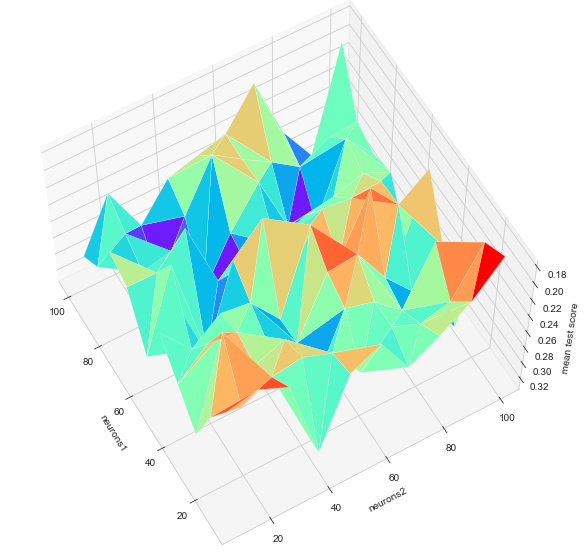

In [68]:
df=pd.DataFrame(nn_gscv.cv_results_['params'])
df.columns=df.columns.str.replace("model__","")
df["mean_test_score"]=-nn_gscv.cv_results_['mean_test_score']
#3d graph
fig = plt.figure(figsize=(20,10))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(df.neurons1, df.neurons2, df.mean_test_score, cmap=cm.rainbow_r, linewidth=0.2)
ax.set_xlabel('neurons1',)
ax.set_ylabel('neurons2')
ax.set_zlabel('mean test score')
ax.view_init(-120, 30)
plt.show()

In [69]:
df.iloc[df.mean_test_score.idxmin,:]

neurons1            10.000000
neurons2           100.000000
mean_test_score      0.176735
Name: 9, dtype: float64

In [70]:
predict_y= np.exp(nn_gscv.predict(test_x))
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 45547.7


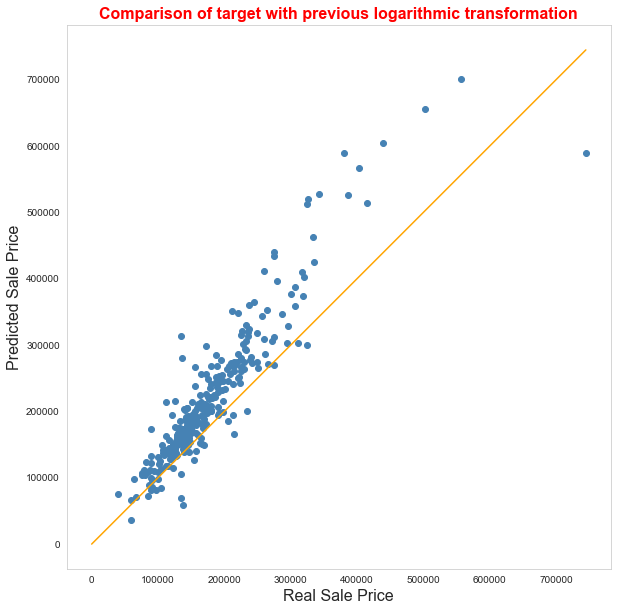

In [71]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

# Summary 

|Method|Calculation time (16MB RAM)|Less error with the target transformed to logarithm?|mean absolute error|
|:------|----------------|---------------------------------------------|-------------------:|
|Linear Regression  |0.7s               |yes                                         |18,188.83|
|K-Nearest Neighbor|   0.7s |no                                  |24,311.16|          
|**Gradient Boosting**|**24.5s**                 |**yes**    |**14,586.30**|
|Random Forest|4m 37s            |no                                          |17,343.90             |
|Decision Tree|0.4s | yes| 25,050.81|
|Support Vector Machine| 0.66s| yes| 16,764,67|
|Neural Network|13m 35s|no|18,184,92|
